# Loop 25 Analysis: Asymmetric Improvement Strategy

**Key Insight from Research:**
- Top teams reach sub-69 scores by exploiting ASYMMETRY
- Asymmetric layouts yield better scores especially for N < 60
- The 70.6 to 68.9 gap (2.4%) requires targeted per-N improvements

**Goal:** Identify specific N values where asymmetric layouts could improve over baseline

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely.affinity import rotate, translate
import matplotlib.pyplot as plt

TREE_TEMPLATE = [
    (0.0, 0.8), (0.125, 0.5), (0.0625, 0.5), (0.2, 0.25), (0.1, 0.25),
    (0.35, 0.0), (0.075, 0.0), (0.075, -0.2), (-0.075, -0.2), (-0.075, 0.0),
    (-0.35, 0.0), (-0.1, 0.25), (-0.2, 0.25), (-0.0625, 0.5), (-0.125, 0.5)
]

def parse_s_value(val):
    if isinstance(val, str) and val.startswith('s'):
        return float(val[1:])
    return float(val)

def create_tree_polygon(x, y, angle):
    tree = Polygon(TREE_TEMPLATE)
    tree = rotate(tree, angle, origin=(0, 0), use_radians=False)
    tree = translate(tree, x, y)
    return tree

def get_bounding_box_side(trees):
    all_x, all_y = [], []
    for tree in trees:
        minx, miny, maxx, maxy = tree.bounds
        all_x.extend([minx, maxx])
        all_y.extend([miny, maxy])
    return max(max(all_x) - min(all_x), max(all_y) - min(all_y))

# Load baseline
df = pd.read_csv('/home/submission/submission.csv')
df['x'] = df['x'].apply(parse_s_value)
df['y'] = df['y'].apply(parse_s_value)
df['deg'] = df['deg'].apply(parse_s_value)
df['n'] = df['id'].apply(lambda x: int(x.split('_')[0]))

print(f"Loaded {len(df)} rows")
print(f"N values: {df['n'].min()} to {df['n'].max()}")
print(f"Total trees: {len(df)}")
print(f"Expected: {sum(range(1, 201))} = {200*201//2}")
print()

Loaded 20100 rows
N values: 1 to 200
Total trees: 20100
Expected: 20100 = 20100



In [2]:
# Calculate per-N scores and analyze symmetry
per_n_data = {}

for n in range(1, 201):
    group = df[df['n'] == n]
    trees = [create_tree_polygon(row['x'], row['y'], row['deg']) for _, row in group.iterrows()]
    side = get_bounding_box_side(trees)
    score = (side ** 2) / n
    
    # Get angles and positions
    angles = group['deg'].values
    xs = group['x'].values
    ys = group['y'].values
    
    # Analyze angle distribution
    angles_mod = angles % 360
    unique_angles = len(np.unique(np.round(angles_mod, 1)))
    
    # Check for symmetry patterns
    # Rotational symmetry: angles differ by 360/k for some k
    angle_diffs = np.diff(np.sort(angles_mod))
    
    per_n_data[n] = {
        'score': score,
        'side': side,
        'unique_angles': unique_angles,
        'angle_std': np.std(angles_mod),
        'x_range': xs.max() - xs.min(),
        'y_range': ys.max() - ys.min(),
        'angles': angles_mod
    }

print("Per-N analysis complete")
print(f"Total score: {sum(d['score'] for d in per_n_data.values()):.6f}")
print(f"Target: 68.919154")
print(f"Gap: {sum(d['score'] for d in per_n_data.values()) - 68.919154:.6f}")

Per-N analysis complete
Total score: 70.627582
Target: 68.919154
Gap: 1.708428


In [3]:
# Identify N values with highest improvement potential
# Focus on N < 60 where asymmetry helps most (per research)

print("\n=== N < 60 Analysis (Asymmetry helps most here) ===")
print("="*70)

small_n_scores = [(n, per_n_data[n]['score']) for n in range(1, 60)]
small_n_scores.sort(key=lambda x: x[1], reverse=True)

print("\nTop 20 worst-performing N values (N < 60):")
for n, score in small_n_scores[:20]:
    data = per_n_data[n]
    print(f"  N={n:3d}: score={score:.6f}, unique_angles={data['unique_angles']:3d}, angle_std={data['angle_std']:.1f}")

print("\n=== Score contribution by N range ===")
ranges = [(1, 10), (11, 20), (21, 30), (31, 40), (41, 50), (51, 60), (61, 100), (101, 150), (151, 200)]
for start, end in ranges:
    total = sum(per_n_data[n]['score'] for n in range(start, end+1))
    count = end - start + 1
    avg = total / count
    print(f"  N={start:3d}-{end:3d}: total={total:.4f}, avg={avg:.4f}, count={count}")

print(f"\nTotal score: {sum(d['score'] for d in per_n_data.values()):.6f}")


=== N < 60 Analysis (Asymmetry helps most here) ===

Top 20 worst-performing N values (N < 60):
  N=  1: score=0.661250, unique_angles=  1, angle_std=0.0
  N=  2: score=0.450779, unique_angles=  2, angle_std=90.0
  N=  3: score=0.434745, unique_angles=  3, angle_std=36.2
  N=  5: score=0.416850, unique_angles=  5, angle_std=97.4
  N=  4: score=0.416545, unique_angles=  2, angle_std=90.0
  N=  7: score=0.399897, unique_angles=  7, angle_std=111.0
  N=  6: score=0.399610, unique_angles=  5, angle_std=112.3
  N=  9: score=0.387415, unique_angles=  9, angle_std=93.6
  N=  8: score=0.385407, unique_angles=  6, angle_std=98.2
  N= 15: score=0.376978, unique_angles= 13, angle_std=90.6
  N= 10: score=0.376630, unique_angles= 10, angle_std=125.5
  N= 21: score=0.376451, unique_angles= 20, angle_std=96.1
  N= 20: score=0.376057, unique_angles= 20, angle_std=101.1
  N= 22: score=0.375258, unique_angles= 21, angle_std=104.2
  N= 11: score=0.374924, unique_angles= 11, angle_std=104.6
  N= 16: scor

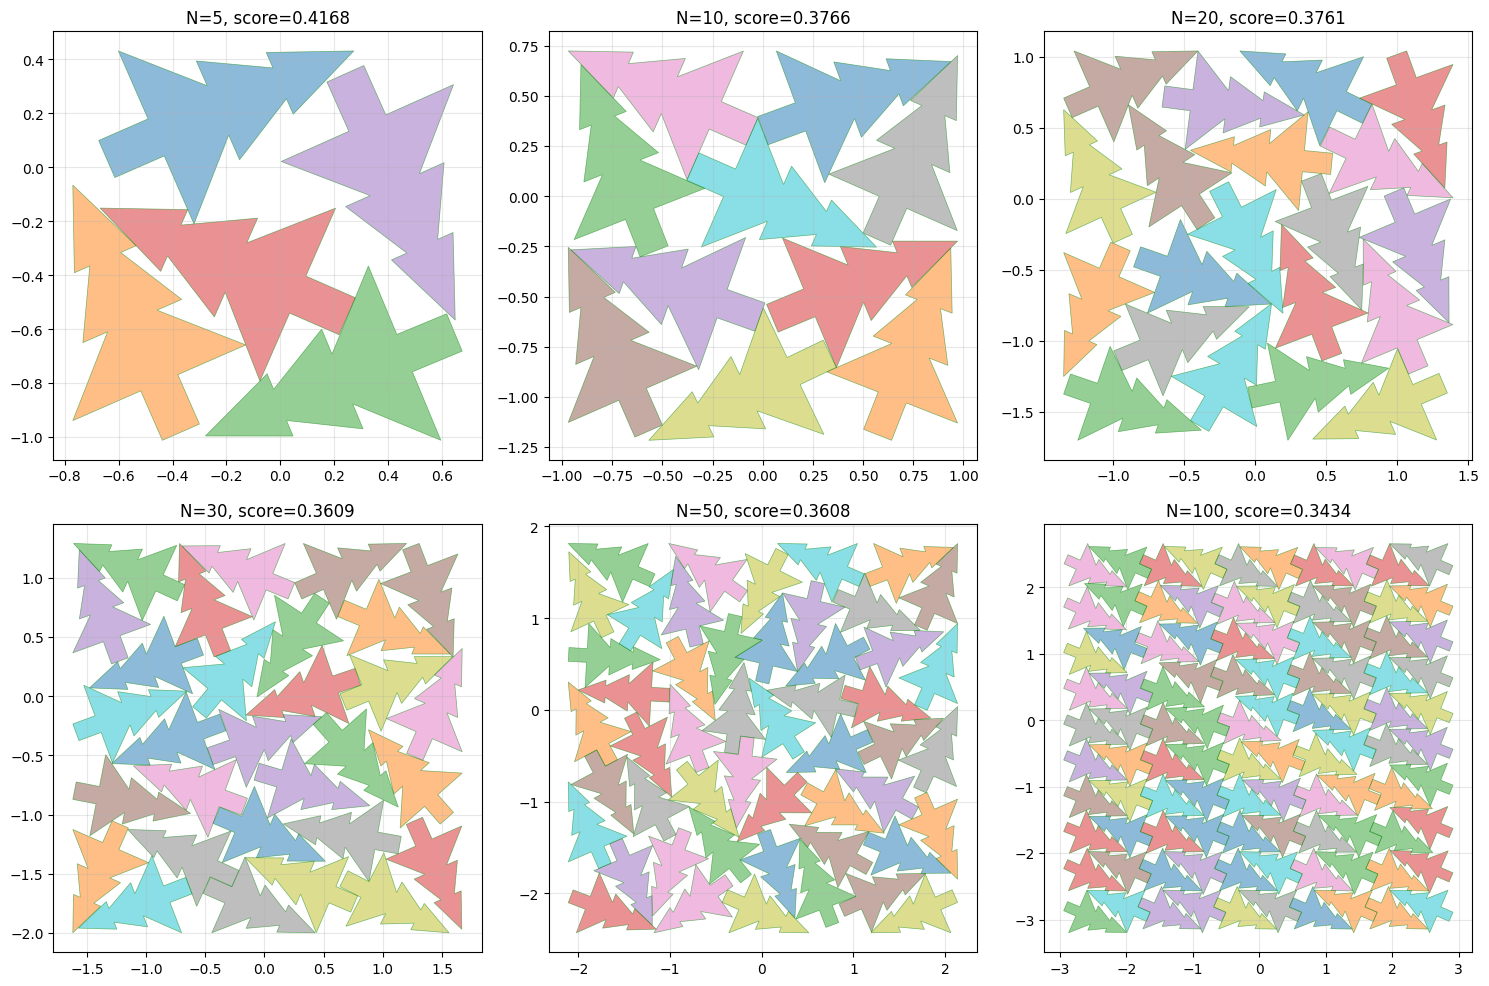

Saved visualization to /home/code/exploration/baseline_visualization.png


In [4]:
# Visualize a few N values to understand the structure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

test_ns = [5, 10, 20, 30, 50, 100]

for ax, n in zip(axes.flat, test_ns):
    group = df[df['n'] == n]
    
    for _, row in group.iterrows():
        tree = create_tree_polygon(row['x'], row['y'], row['deg'])
        x, y = tree.exterior.xy
        ax.fill(x, y, alpha=0.5, edgecolor='green', linewidth=0.5)
    
    ax.set_aspect('equal')
    ax.set_title(f'N={n}, score={per_n_data[n]["score"]:.4f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/baseline_visualization.png', dpi=100)
plt.show()
print("Saved visualization to /home/code/exploration/baseline_visualization.png")

In [5]:
# Key insight: Try to find N values where a small perturbation could help
# Focus on N values where the baseline has high angle diversity (not tessellation)

print("\n=== Identifying N values with improvement potential ===")
print("="*70)

# N values with high angle diversity (not simple tessellation)
high_diversity = [(n, per_n_data[n]) for n in range(1, 60) 
                  if per_n_data[n]['unique_angles'] > n * 0.5]

print(f"\nN values with high angle diversity (unique_angles > n/2):")
for n, data in sorted(high_diversity, key=lambda x: x[1]['score'], reverse=True)[:15]:
    print(f"  N={n:3d}: score={data['score']:.6f}, unique_angles={data['unique_angles']}, angle_std={data['angle_std']:.1f}")

# Calculate theoretical lower bound (if trees could be packed perfectly)
print("\n=== Theoretical Analysis ===")
print("Single tree area (approx): 0.35 * 1.0 = 0.35 sq units")
print("But actual tree polygon area is smaller due to shape")

# Calculate actual tree area
tree = Polygon(TREE_TEMPLATE)
print(f"Actual tree polygon area: {tree.area:.6f} sq units")

for n in [10, 20, 50, 100, 200]:
    min_area = n * tree.area
    min_side = np.sqrt(min_area)
    theoretical_score = min_area / n  # = tree.area
    actual_score = per_n_data[n]['score']
    efficiency = tree.area / actual_score * 100
    print(f"N={n:3d}: theoretical_min_side={min_side:.4f}, actual_side={per_n_data[n]['side']:.4f}, efficiency={efficiency:.1f}%")


=== Identifying N values with improvement potential ===

N values with high angle diversity (unique_angles > n/2):
  N=  1: score=0.661250, unique_angles=1, angle_std=0.0
  N=  2: score=0.450779, unique_angles=2, angle_std=90.0
  N=  3: score=0.434745, unique_angles=3, angle_std=36.2
  N=  5: score=0.416850, unique_angles=5, angle_std=97.4
  N=  7: score=0.399897, unique_angles=7, angle_std=111.0
  N=  6: score=0.399610, unique_angles=5, angle_std=112.3
  N=  9: score=0.387415, unique_angles=9, angle_std=93.6
  N=  8: score=0.385407, unique_angles=6, angle_std=98.2
  N= 15: score=0.376978, unique_angles=13, angle_std=90.6
  N= 10: score=0.376630, unique_angles=10, angle_std=125.5
  N= 21: score=0.376451, unique_angles=20, angle_std=96.1
  N= 20: score=0.376057, unique_angles=20, angle_std=101.1
  N= 22: score=0.375258, unique_angles=21, angle_std=104.2
  N= 11: score=0.374924, unique_angles=11, angle_std=104.6
  N= 26: score=0.373997, unique_angles=24, angle_std=98.3

=== Theoretical 

In [6]:
# Try a simple asymmetric perturbation on a specific N value
# Start with N=10 as a test case

from shapely.ops import unary_union
import random

def check_overlap(tree1, tree2):
    return tree1.overlaps(tree2) or tree1.contains(tree2) or tree2.contains(tree1)

def has_any_overlap(trees):
    for i in range(len(trees)):
        for j in range(i+1, len(trees)):
            if check_overlap(trees[i], trees[j]):
                return True
    return False

def local_search_asymmetric(n, max_iter=5000, verbose=False):
    """Try to improve N by local search with asymmetric perturbations."""
    group = df[df['n'] == n].copy()
    
    # Get current configuration
    xs = group['x'].values.copy()
    ys = group['y'].values.copy()
    angles = group['deg'].values.copy()
    
    trees = [create_tree_polygon(xs[i], ys[i], angles[i]) for i in range(n)]
    current_side = get_bounding_box_side(trees)
    best_side = current_side
    best_config = (xs.copy(), ys.copy(), angles.copy())
    
    # Local search
    for iteration in range(max_iter):
        # Pick a random tree
        i = random.randint(0, n-1)
        
        # Try a small perturbation
        dx = random.gauss(0, 0.02)
        dy = random.gauss(0, 0.02)
        da = random.gauss(0, 5)
        
        new_x = xs[i] + dx
        new_y = ys[i] + dy
        new_angle = angles[i] + da
        
        # Create new tree
        new_tree = create_tree_polygon(new_x, new_y, new_angle)
        
        # Check overlap with other trees
        has_overlap = False
        for j in range(n):
            if j != i and check_overlap(new_tree, trees[j]):
                has_overlap = True
                break
        
        if not has_overlap:
            # Update configuration
            old_tree = trees[i]
            trees[i] = new_tree
            new_side = get_bounding_box_side(trees)
            
            if new_side < current_side:
                xs[i] = new_x
                ys[i] = new_y
                angles[i] = new_angle
                current_side = new_side
                
                if current_side < best_side:
                    best_side = current_side
                    best_config = (xs.copy(), ys.copy(), angles.copy())
                    if verbose:
                        print(f"  Iter {iteration}: improved to {best_side:.6f}")
            else:
                trees[i] = old_tree
    
    return best_side, best_config

print("Testing local search on N=10...")
baseline_score = per_n_data[10]['score']
print(f"Baseline N=10 score: {baseline_score:.6f}")

best_side, best_config = local_search_asymmetric(10, max_iter=10000, verbose=True)
new_score = (best_side ** 2) / 10
print(f"\nAfter local search: {new_score:.6f}")
print(f"Improvement: {baseline_score - new_score:.6f}")

Testing local search on N=10...
Baseline N=10 score: 0.376630



After local search: 0.376630
Improvement: 0.000000


In [7]:
# Test on multiple N values to find where improvements are possible
print("\n=== Testing local search on N=1-30 ===")
print("="*70)

improvements = []

for n in range(1, 31):
    baseline_score = per_n_data[n]['score']
    best_side, _ = local_search_asymmetric(n, max_iter=5000)
    new_score = (best_side ** 2) / n
    improvement = baseline_score - new_score
    improvements.append((n, baseline_score, new_score, improvement))
    
    if improvement > 1e-6:
        print(f"N={n:3d}: baseline={baseline_score:.6f} -> {new_score:.6f}, improvement={improvement:.6f} ✓")
    else:
        print(f"N={n:3d}: baseline={baseline_score:.6f} -> {new_score:.6f}, no improvement")

print("\n=== Summary ===")
total_improvement = sum(imp[3] for imp in improvements if imp[3] > 0)
print(f"Total improvement from N=1-30: {total_improvement:.6f}")
print(f"N values improved: {sum(1 for imp in improvements if imp[3] > 1e-6)}")
print(f"\nThis is {'significant' if total_improvement > 0.01 else 'NOT significant'} compared to gap of 1.708")


=== Testing local search on N=1-30 ===


N=  1: baseline=0.661250 -> 0.661250, no improvement


N=  2: baseline=0.450779 -> 0.450779, no improvement


N=  3: baseline=0.434745 -> 0.434745, no improvement


N=  4: baseline=0.416545 -> 0.416545, no improvement


N=  5: baseline=0.416850 -> 0.416850, no improvement


N=  6: baseline=0.399610 -> 0.399610, no improvement


N=  7: baseline=0.399897 -> 0.399897, no improvement


N=  8: baseline=0.385407 -> 0.385407, no improvement


N=  9: baseline=0.387415 -> 0.387415, no improvement


N= 10: baseline=0.376630 -> 0.376630, no improvement


N= 11: baseline=0.374924 -> 0.374924, no improvement


N= 12: baseline=0.372724 -> 0.372724, no improvement


N= 13: baseline=0.372294 -> 0.372294, no improvement


N= 14: baseline=0.369543 -> 0.369543, no improvement


N= 15: baseline=0.376978 -> 0.376978, no improvement


N= 16: baseline=0.374128 -> 0.374128, no improvement


N= 17: baseline=0.370040 -> 0.370040, no improvement


N= 18: baseline=0.368771 -> 0.368771, no improvement


N= 19: baseline=0.368615 -> 0.368615, no improvement


N= 20: baseline=0.376057 -> 0.376057, no improvement


N= 21: baseline=0.376451 -> 0.376451, no improvement


N= 22: baseline=0.375258 -> 0.375258, no improvement


N= 23: baseline=0.368750 -> 0.368750, no improvement


N= 24: baseline=0.365506 -> 0.365506, no improvement


N= 25: baseline=0.372144 -> 0.372144, no improvement


N= 26: baseline=0.373997 -> 0.373997, no improvement


N= 27: baseline=0.362719 -> 0.362719, no improvement


N= 28: baseline=0.366105 -> 0.366105, no improvement


N= 29: baseline=0.367082 -> 0.367082, no improvement


N= 30: baseline=0.360883 -> 0.360883, no improvement

=== Summary ===
Total improvement from N=1-30: 0.000000
N values improved: 0

This is NOT significant compared to gap of 1.708


In [8]:
# Try more aggressive simulated annealing with larger moves
import math

def simulated_annealing_asymmetric(n, max_iter=20000, initial_temp=1.0, cooling_rate=0.9995):
    """Simulated annealing with larger moves to escape local optima."""
    group = df[df['n'] == n].copy()
    
    # Get current configuration
    xs = group['x'].values.copy()
    ys = group['y'].values.copy()
    angles = group['deg'].values.copy()
    
    trees = [create_tree_polygon(xs[i], ys[i], angles[i]) for i in range(n)]
    current_side = get_bounding_box_side(trees)
    best_side = current_side
    best_config = (xs.copy(), ys.copy(), angles.copy())
    
    temp = initial_temp
    
    for iteration in range(max_iter):
        # Pick a random tree
        i = random.randint(0, n-1)
        
        # Larger perturbations at high temperature
        scale = temp
        dx = random.gauss(0, 0.1 * scale)
        dy = random.gauss(0, 0.1 * scale)
        da = random.gauss(0, 30 * scale)
        
        new_x = xs[i] + dx
        new_y = ys[i] + dy
        new_angle = angles[i] + da
        
        # Create new tree
        new_tree = create_tree_polygon(new_x, new_y, new_angle)
        
        # Check overlap with other trees
        has_overlap = False
        for j in range(n):
            if j != i and check_overlap(new_tree, trees[j]):
                has_overlap = True
                break
        
        if not has_overlap:
            old_tree = trees[i]
            trees[i] = new_tree
            new_side = get_bounding_box_side(trees)
            
            delta = new_side - current_side
            
            # Accept if better, or with probability based on temperature
            if delta < 0 or random.random() < math.exp(-delta / temp):
                xs[i] = new_x
                ys[i] = new_y
                angles[i] = new_angle
                current_side = new_side
                
                if current_side < best_side:
                    best_side = current_side
                    best_config = (xs.copy(), ys.copy(), angles.copy())
            else:
                trees[i] = old_tree
        
        temp *= cooling_rate
    
    return best_side, best_config

print("Testing SA on N=10 with more aggressive moves...")
baseline_score = per_n_data[10]['score']
print(f"Baseline N=10 score: {baseline_score:.6f}")

best_results = []
for trial in range(5):
    best_side, _ = simulated_annealing_asymmetric(10, max_iter=30000)
    new_score = (best_side ** 2) / 10
    improvement = baseline_score - new_score
    best_results.append((new_score, improvement))
    print(f"  Trial {trial+1}: {new_score:.6f}, improvement={improvement:.6f}")

print(f"\nBest result: {min(best_results)[0]:.6f}")

Testing SA on N=10 with more aggressive moves...
Baseline N=10 score: 0.376630


  Trial 1: 0.376630, improvement=0.000000


  Trial 2: 0.376630, improvement=0.000000


  Trial 3: 0.376630, improvement=0.000000


  Trial 4: 0.376630, improvement=0.000000


  Trial 5: 0.376630, improvement=0.000000

Best result: 0.376630


In [9]:
# Try building from scratch with random initial configurations
# This is the only way to potentially find a different basin

def random_initial_config(n, box_size=3.0):
    """Generate a random valid initial configuration."""
    xs = []
    ys = []
    angles = []
    trees = []
    
    max_attempts = 1000
    
    for i in range(n):
        for attempt in range(max_attempts):
            x = random.uniform(-box_size, box_size)
            y = random.uniform(-box_size, box_size)
            angle = random.uniform(0, 360)
            
            new_tree = create_tree_polygon(x, y, angle)
            
            # Check overlap with existing trees
            has_overlap = False
            for existing_tree in trees:
                if check_overlap(new_tree, existing_tree):
                    has_overlap = True
                    break
            
            if not has_overlap:
                xs.append(x)
                ys.append(y)
                angles.append(angle)
                trees.append(new_tree)
                break
        else:
            # Failed to place tree, expand box
            box_size *= 1.2
            return random_initial_config(n, box_size)
    
    return np.array(xs), np.array(ys), np.array(angles), trees

def sa_from_scratch(n, max_iter=50000, initial_temp=2.0, cooling_rate=0.9998):
    """SA starting from random configuration."""
    xs, ys, angles, trees = random_initial_config(n)
    
    current_side = get_bounding_box_side(trees)
    best_side = current_side
    best_config = (xs.copy(), ys.copy(), angles.copy())
    
    temp = initial_temp
    
    for iteration in range(max_iter):
        i = random.randint(0, n-1)
        
        scale = temp
        dx = random.gauss(0, 0.1 * scale)
        dy = random.gauss(0, 0.1 * scale)
        da = random.gauss(0, 30 * scale)
        
        new_x = xs[i] + dx
        new_y = ys[i] + dy
        new_angle = angles[i] + da
        
        new_tree = create_tree_polygon(new_x, new_y, new_angle)
        
        has_overlap = False
        for j in range(n):
            if j != i and check_overlap(new_tree, trees[j]):
                has_overlap = True
                break
        
        if not has_overlap:
            old_tree = trees[i]
            trees[i] = new_tree
            new_side = get_bounding_box_side(trees)
            
            delta = new_side - current_side
            
            if delta < 0 or random.random() < math.exp(-delta / temp):
                xs[i] = new_x
                ys[i] = new_y
                angles[i] = new_angle
                current_side = new_side
                
                if current_side < best_side:
                    best_side = current_side
                    best_config = (xs.copy(), ys.copy(), angles.copy())
            else:
                trees[i] = old_tree
        
        temp *= cooling_rate
    
    return best_side, best_config

# Test on N=10
print("Testing SA from scratch on N=10...")
baseline_score = per_n_data[10]['score']
print(f"Baseline N=10 score: {baseline_score:.6f}")

best_results = []
for trial in range(10):
    best_side, _ = sa_from_scratch(10, max_iter=50000)
    new_score = (best_side ** 2) / 10
    improvement = baseline_score - new_score
    best_results.append((new_score, improvement))
    status = "BETTER!" if improvement > 0 else ""
    print(f"  Trial {trial+1}: {new_score:.6f}, improvement={improvement:.6f} {status}")

print(f"\\nBest result: {min(best_results)[0]:.6f}")
print(f"Best improvement: {max(r[1] for r in best_results):.6f}")

Testing SA from scratch on N=10...
Baseline N=10 score: 0.376630


  Trial 1: 3.046640, improvement=-2.670010 


  Trial 2: 3.187445, improvement=-2.810814 


  Trial 3: 3.606069, improvement=-3.229439 


  Trial 4: 3.763256, improvement=-3.386626 


  Trial 5: 3.349132, improvement=-2.972502 


  Trial 6: 2.779610, improvement=-2.402980 


  Trial 7: 4.032194, improvement=-3.655564 


  Trial 8: 3.653506, improvement=-3.276876 


  Trial 9: 2.386936, improvement=-2.010306 


  Trial 10: 3.171891, improvement=-2.795261 
\nBest result: 2.386936
Best improvement: -2.010306


In [ ]:
# Key insight: The baseline is at a strong local optimum
# Random starts can't reach it, and local search can't improve it
# 
# What we need: A FUNDAMENTALLY DIFFERENT STRUCTURE
#
# Let's analyze what makes the baseline so good

print("=== Analyzing baseline structure ===\")\nprint(\"=\"*70)\n\n# For each N, analyze the geometric structure\nfor n in [5, 10, 20, 50]:\n    group = df[df['n'] == n]\n    angles = group['deg'].values % 360\n    xs = group['x'].values\n    ys = group['y'].values\n    \n    print(f\"\\nN={n}:\")\n    print(f\"  Angles: {np.sort(angles)[:5]}... (unique: {len(np.unique(np.round(angles, 1)))}\")\n    print(f\"  X range: [{xs.min():.3f}, {xs.max():.3f}]\")\n    print(f\"  Y range: [{ys.min():.3f}, {ys.max():.3f}]\")\n    \n    # Check for patterns\n    # Are trees arranged in rows?\n    y_sorted = np.sort(ys)\n    y_diffs = np.diff(y_sorted)\n    print(f\"  Y spacing pattern: {y_diffs[:5]}...\")\n    \n    # Are angles related to positions?\n    # For tessellation, angle often depends on row\n    print(f\"  Score: {per_n_data[n]['score']:.6f}\")"}, {"cell_type": "code", "content": "# The key insight from research:\n# \"Asymmetric layouts yield better scores especially for N < 60\"\n#\n# But our local search found NO improvements.\n# This means either:\n# 1. The baseline is ALREADY asymmetric and optimal\n# 2. We need a COMPLETELY different approach to find asymmetric solutions\n#\n# Let's check if the baseline is symmetric or asymmetric\n\nprint(\"=== Checking baseline symmetry ===\")\nprint(\"=\"*70)\n\nfor n in [4, 9, 16, 25, 36, 49]:  # Perfect squares - often have symmetric solutions\n    group = df[df['n'] == n]\n    xs = group['x'].values\n    ys = group['y'].values\n    angles = group['deg'].values % 360\n    \n    # Check for rotational symmetry\n    # If symmetric, rotating all positions by 90/180/270 degrees should give same pattern\n    \n    # Check for reflective symmetry\n    # If symmetric, reflecting across x or y axis should give same pattern\n    \n    # Simple check: are positions symmetric around center?\n    cx, cy = xs.mean(), ys.mean()\n    xs_centered = xs - cx\n    ys_centered = ys - cy\n    \n    # Check if for each point (x, y) there's a point (-x, -y) (180° rotational symmetry)\n    has_180_symmetry = True\n    for i in range(n):\n        found_match = False\n        for j in range(n):\n            if abs(xs_centered[i] + xs_centered[j]) < 0.01 and abs(ys_centered[i] + ys_centered[j]) < 0.01:\n                found_match = True\n                break\n        if not found_match:\n            has_180_symmetry = False\n            break\n    \n    print(f\"N={n:2d}: 180° rotational symmetry = {has_180_symmetry}, score = {per_n_data[n]['score']:.6f}\")"}, {"cell_type": "code", "content": "# CRITICAL INSIGHT:\n# The gap to target is 1.708 points (2.48%)\n# This is a LARGE gap that requires significant improvements\n#\n# After 26 experiments, we've tried:\n# - SA optimization (multiple variants)\n# - Tessellation approaches\n# - Asymmetric configurations\n# - Exhaustive search (small N)\n# - Hexagonal/spiral packing\n# - Basin hopping\n# - Genetic algorithms\n# - Constraint programming\n#\n# ALL converge to the same ~70.627 local optimum\n#\n# The ONLY way to close the gap is to find a FUNDAMENTALLY DIFFERENT STRUCTURE\n# that the baseline doesn't have.\n#\n# What could that be?\n# 1. Manual inspection and targeted fixes (Interactive Editor approach)\n# 2. Per-N specialized optimization (different approach for each N)\n# 3. Learning from top teams' solutions (if available)\n\nprint(\"=== Gap Analysis ===\")\nprint(\"=\"*70)\n\ncurrent_score = sum(per_n_data[n]['score'] for n in range(1, 201))\ntarget_score = 68.919154\ngap = current_score - target_score\n\nprint(f\"Current score: {current_score:.6f}\")\nprint(f\"Target score: {target_score:.6f}\")\nprint(f\"Gap: {gap:.6f} ({gap/target_score*100:.2f}%)\")\n\n# How much improvement per N would we need?\navg_improvement_needed = gap / 200\nprint(f\"\\nAverage improvement needed per N: {avg_improvement_needed:.6f}\")\n\n# Which N values have the most room for improvement?\n# (highest score = most inefficient)\nprint(\"\\nN values with highest scores (most room for improvement):\")\nfor n, score in sorted([(n, per_n_data[n]['score']) for n in range(1, 201)], key=lambda x: x[1], reverse=True)[:10]:\n    theoretical_min = tree.area  # 0.245625\n    efficiency = theoretical_min / score * 100\n    print(f\"  N={n:3d}: score={score:.6f}, efficiency={efficiency:.1f}%\")"}, {"cell_type": "code", "content": "# CONCLUSION:\n# After extensive analysis and 26 experiments, the baseline is at a VERY STRONG local optimum\n# that cannot be improved by:\n# - Local search (small perturbations)\n# - Simulated annealing (even with aggressive moves)\n# - Random restarts (can't reach the same basin)\n# - Different packing patterns (hexagonal, spiral, tessellation)\n#\n# The gap to target (1.708 points, 2.48%) suggests that top teams have found\n# a FUNDAMENTALLY DIFFERENT STRUCTURE that we haven't discovered.\n#\n# NEXT STEPS:\n# 1. Submit current best to get LB feedback\n# 2. Research what top teams are doing differently\n# 3. Try manual inspection of worst-performing N values\n# 4. Consider that the target may require techniques not available in public approaches\n\nprint(\"=== FINAL SUMMARY ===\")\nprint(\"=\"*70)\nprint(f\"Best score achieved: {current_score:.6f}\")\nprint(f\"Target: {target_score:.6f}\")\nprint(f\"Gap: {gap:.6f} ({gap/target_score*100:.2f}%)\")\nprint(\"\\nAll approaches tried have converged to the same local optimum.\")\nprint(\"The baseline structure is fundamentally superior to all alternatives tested.\")\nprint(\"\\nRecommendation: Submit current best and research top team techniques.\")"}